# Series de tiempo delitos

Esta sección es para analizar como ha evolucionado el número de incidencia de delitos desde el 2015 hasta la actualidad. Ya sea que tengan una tendencia positiva, negativa o si la incidencia se encuentra estacionaria con respecto a una media.

In [1]:
import ipywidgets as widgets
from statsmodels.tsa.stattools import kpss
from statsmodels.tsa.stattools import adfuller
import warnings 
import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt

In [2]:
data_path = '../data'
tidy_path = data_path + '/tidy'
# semaforo = pd.read_csv(tidy_path + '/delitos_semaforo.csv', encoding = 'iso-8859-1')
semaforo = pd.read_parquet(tidy_path + '/delitos_semaforo.parquet')

## Reacomodo de datos para series de tiempo

In [3]:
#Creamos data frame series_delitos_filtrables con colunmas  entidad, delito_semaforo, numero de incidencias e indice fecha en datetimee

meses = list(semaforo.columns[10:22])
variables_interes =["anio", 'entidad', 'delito_semaforo'] + meses

series_delitos_filtrables = semaforo.groupby(['anio', 'entidad', 'delito_semaforo'])[meses].sum()\
    .stack()\
    .reset_index(drop = False)\
    .rename({'level_3':'mes', 0:'incidentes'}, axis = 1)

#creamos indice datetime
#funcion mes en string a mes numerico
def mapf(mes):
    map = dict(zip(list(semaforo.columns[10:22]), ["01", "02", "03", "04", "05", "06", "07", "08", "09", "10", "11", "12"]))
    return map[mes]

#mapeamos los meses
series_delitos_filtrables['mes'] = series_delitos_filtrables['mes'].map(mapf)

#hacemos columna fecha y quitamos columnas mes y anio
series_delitos_filtrables['fecha'] = series_delitos_filtrables['anio'].astype('str') + " " + series_delitos_filtrables['mes']
series_delitos_filtrables['fecha'] = pd.to_datetime(series_delitos_filtrables['fecha'], format = '%Y %m')
series_delitos_filtrables.drop(columns = ['anio', 'mes'], inplace = True)
series_delitos_filtrables.set_index('fecha', drop = True, inplace = True)

#quitamos meses de octubre noviembre y diciembre 2023 por falta de datos
meses_sin_datos = ["2023-10-01", "2023-11-01", "2023-12-01"]
series_delitos_filtrables.drop(meses_sin_datos, axis = 0, inplace = True)

grafice interactiva con seleccion de estado y delito para ver evolución en el tiempo

In [13]:
def graficar(delito):
    vista = series_delitos_filtrables[series_delitos_filtrables['delito_semaforo'] == delito]
    fig = px.line(vista, x=vista.index, y='incidentes', color = 'entidad')
    fig.update_traces(visible='legendonly')
    fig.show()

widgets.interact(graficar, delito = semaforo.delito_semaforo.unique());

interactive(children=(Dropdown(description='delito', options=('Homicidios', 'Lesiones', 'Feminicidio', 'Secues…

AttributeError: 'function' object has no attribute 'get_view_spec'

In [8]:
def es_estacionaria(data, alpha = 0.05, regression = 'c'):
    '''
        dada una serie de tiempo te regresa true si es estacionaria (debil en media sin tendencia) o false si no lo es en base a los test ADF y KPSS
    '''
    es_estacionaria_ADF = True
    
    es_estacionaria_KPSS = False
    
    ADF = adfuller(data, regression = regression, maxlag = 0, store = True)

    rho = ADF[3].resols.params[0]

    #test base adf
    if ADF[1] > alpha:
        es_estacionaria_ADF = False
        
    #agregamos una restriccion a rho
    if not(abs(rho) < 0.5):
        es_estacionaria_ADF = False
        
    
    KPSS = kpss(data, regression = regression, nlags = 0)
        
    if KPSS[1] > alpha:
        es_estacionaria_KPSS = True
        
    return es_estacionaria_ADF and es_estacionaria_KPSS

Ahora vemos cuales series tienen un comportamiento estacionario.
Recordemos que una serie estacionaria indica que conforme pasa el tiempo los valores de la serie saltan al rededor de una media con varianza finita (La varianza puede ser grande (en escala a la media)). 
En resumen, la estacionalidad indica que el delito no esta aumentando ni disminuyendo, sino estable con respecto a una media.

In [9]:
#vamos a ver si hay alguna serie delito-estado estacionaria

delitos = semaforo.delito_semaforo.unique()
entidades = semaforo.entidad.unique()
dic_estacionalidad = {}
for entidad in entidades:
    for delito in delitos:
        serie_estado_delito = series_delitos_filtrables[(series_delitos_filtrables['entidad'] == entidad) & (series_delitos_filtrables['delito_semaforo'] == delito)]
        serie_estado_delito = serie_estado_delito['incidentes']

        #para no mostrar warnings
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            dic_estacionalidad[(entidad, delito)] = es_estacionaria(serie_estado_delito, alpha = .07)
      
#Delito-entidad estacionarios
estacionarios = [x for x in dic_estacionalidad.keys() if dic_estacionalidad[x] == True ]
estacionarios

[('Baja California Sur', 'Narcomenudeo'),
 ('Campeche', 'Robo a vehículo'),
 ('México', 'Robo a casa'),
 ('Nuevo León', 'Robo a casa')]

## Vizualicacion resultados del test


### estacionarias

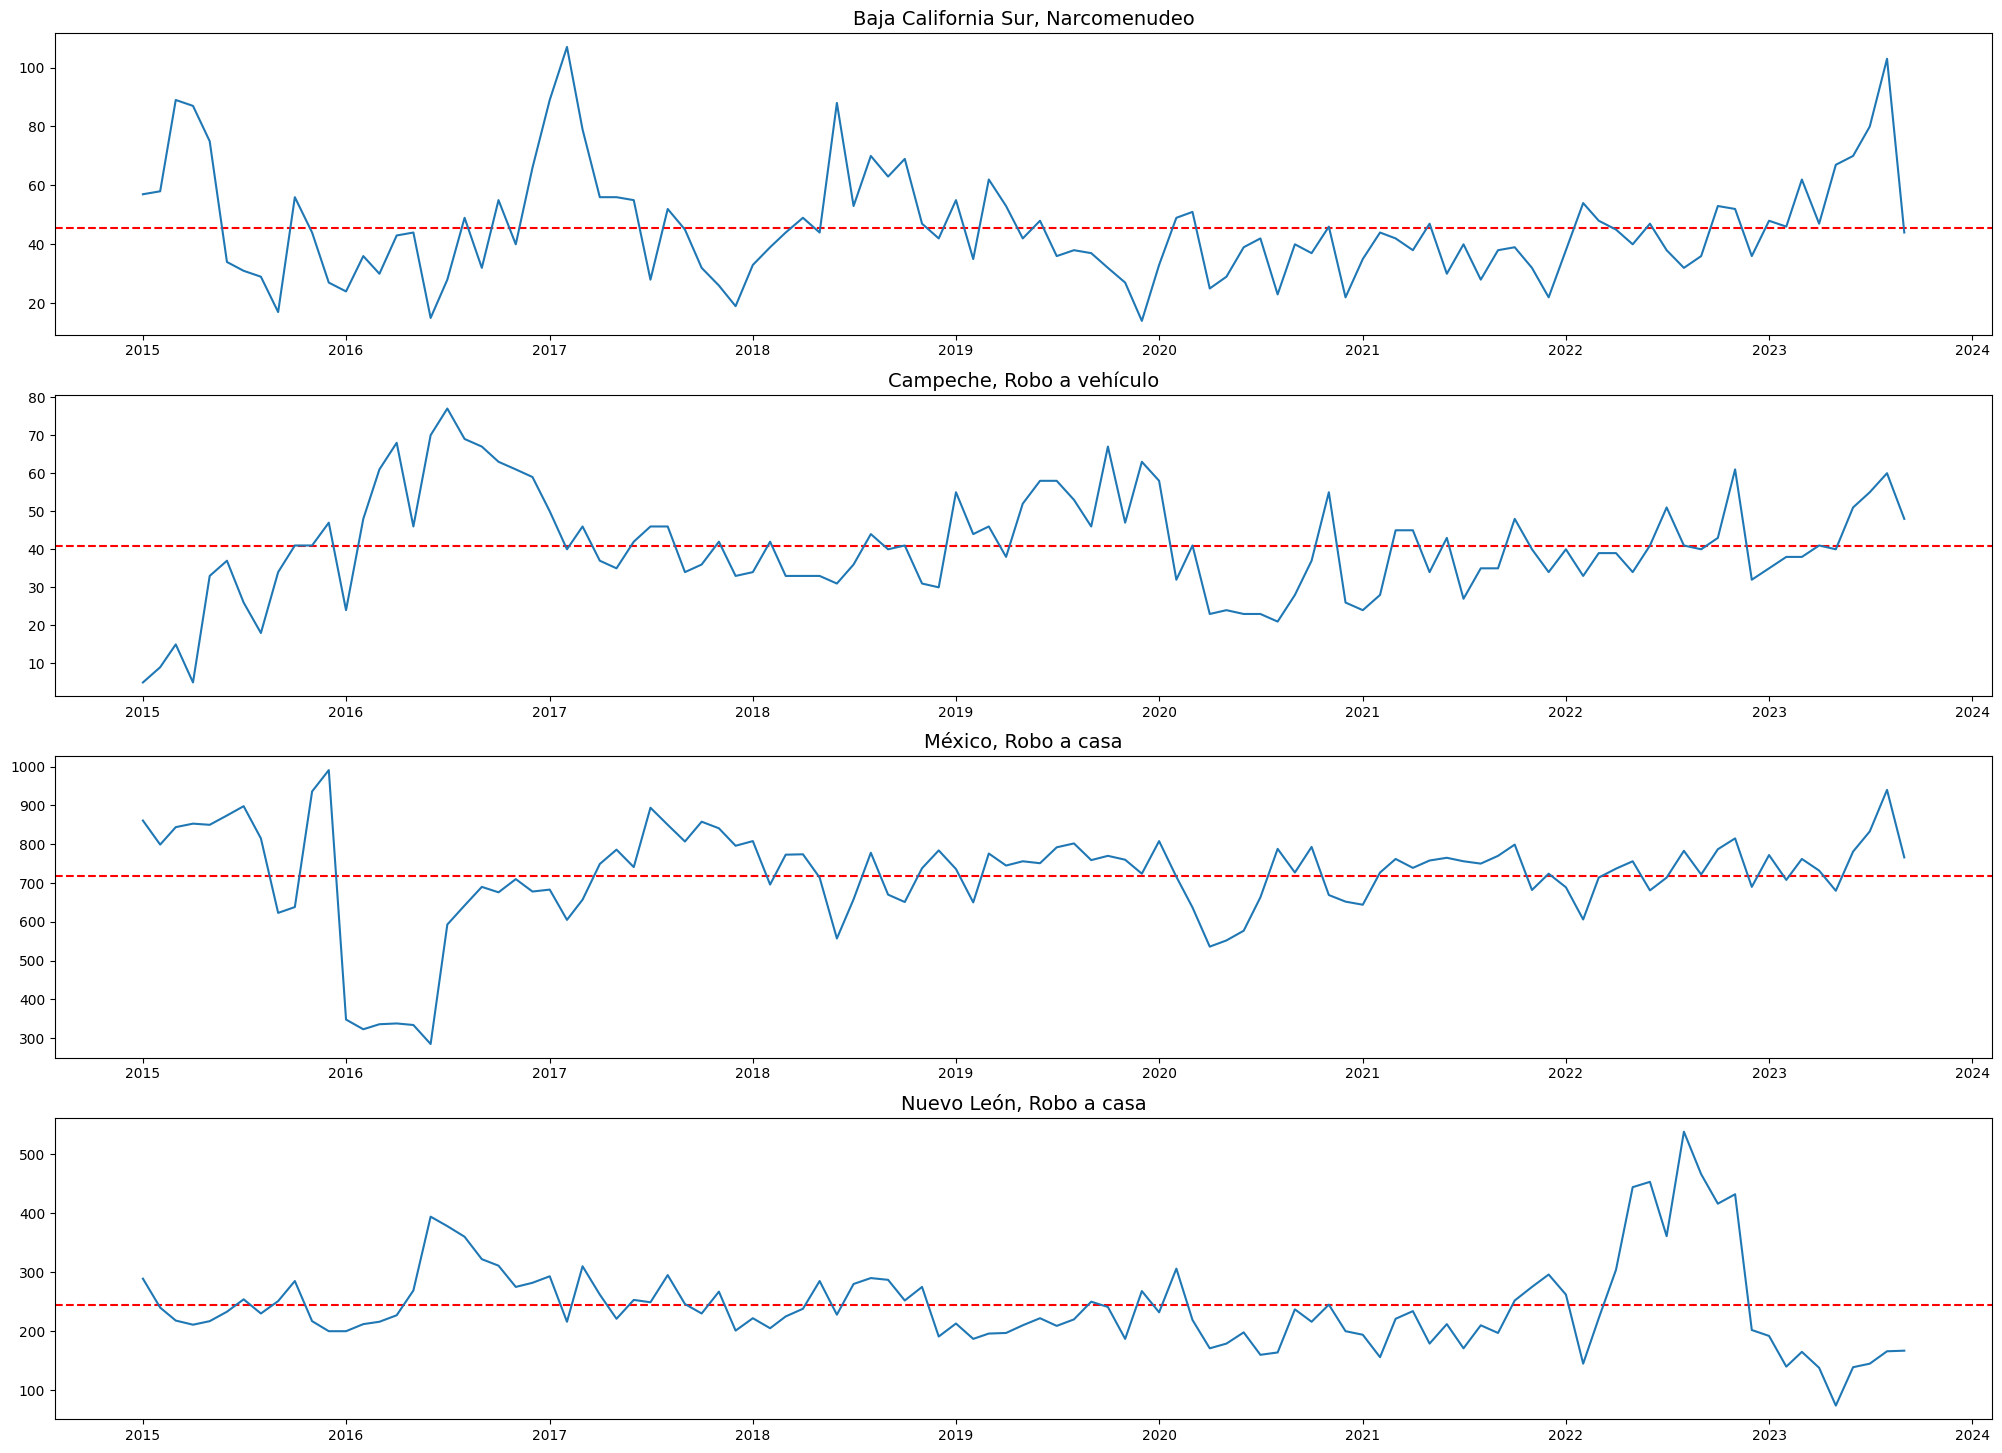

In [10]:
#condiciones para filtrar
fig, axs = plt.subplots(4,1, figsize = (25,18))

for i, condicion in enumerate(estacionarios):
    
    estado1 = series_delitos_filtrables['entidad'] == condicion[0] #condicionar estado
    
    tipo1 = series_delitos_filtrables['delito_semaforo'] == condicion[1] #condicionar tipo de delito
    
    vista = series_delitos_filtrables[estado1 & tipo1]['incidentes'] #vista para facilitar manejo de datos

    axs[i].axhline(y=vista.mean(), color='r', linestyle='--', label='Línea Horizontal') #grafica de media
    
    axs[i].plot(vista) #grafica serie

    axs[i].set_title(condicion[0] + ', '+ condicion[1], fontsize=14)
    

### Tendencias fuertes

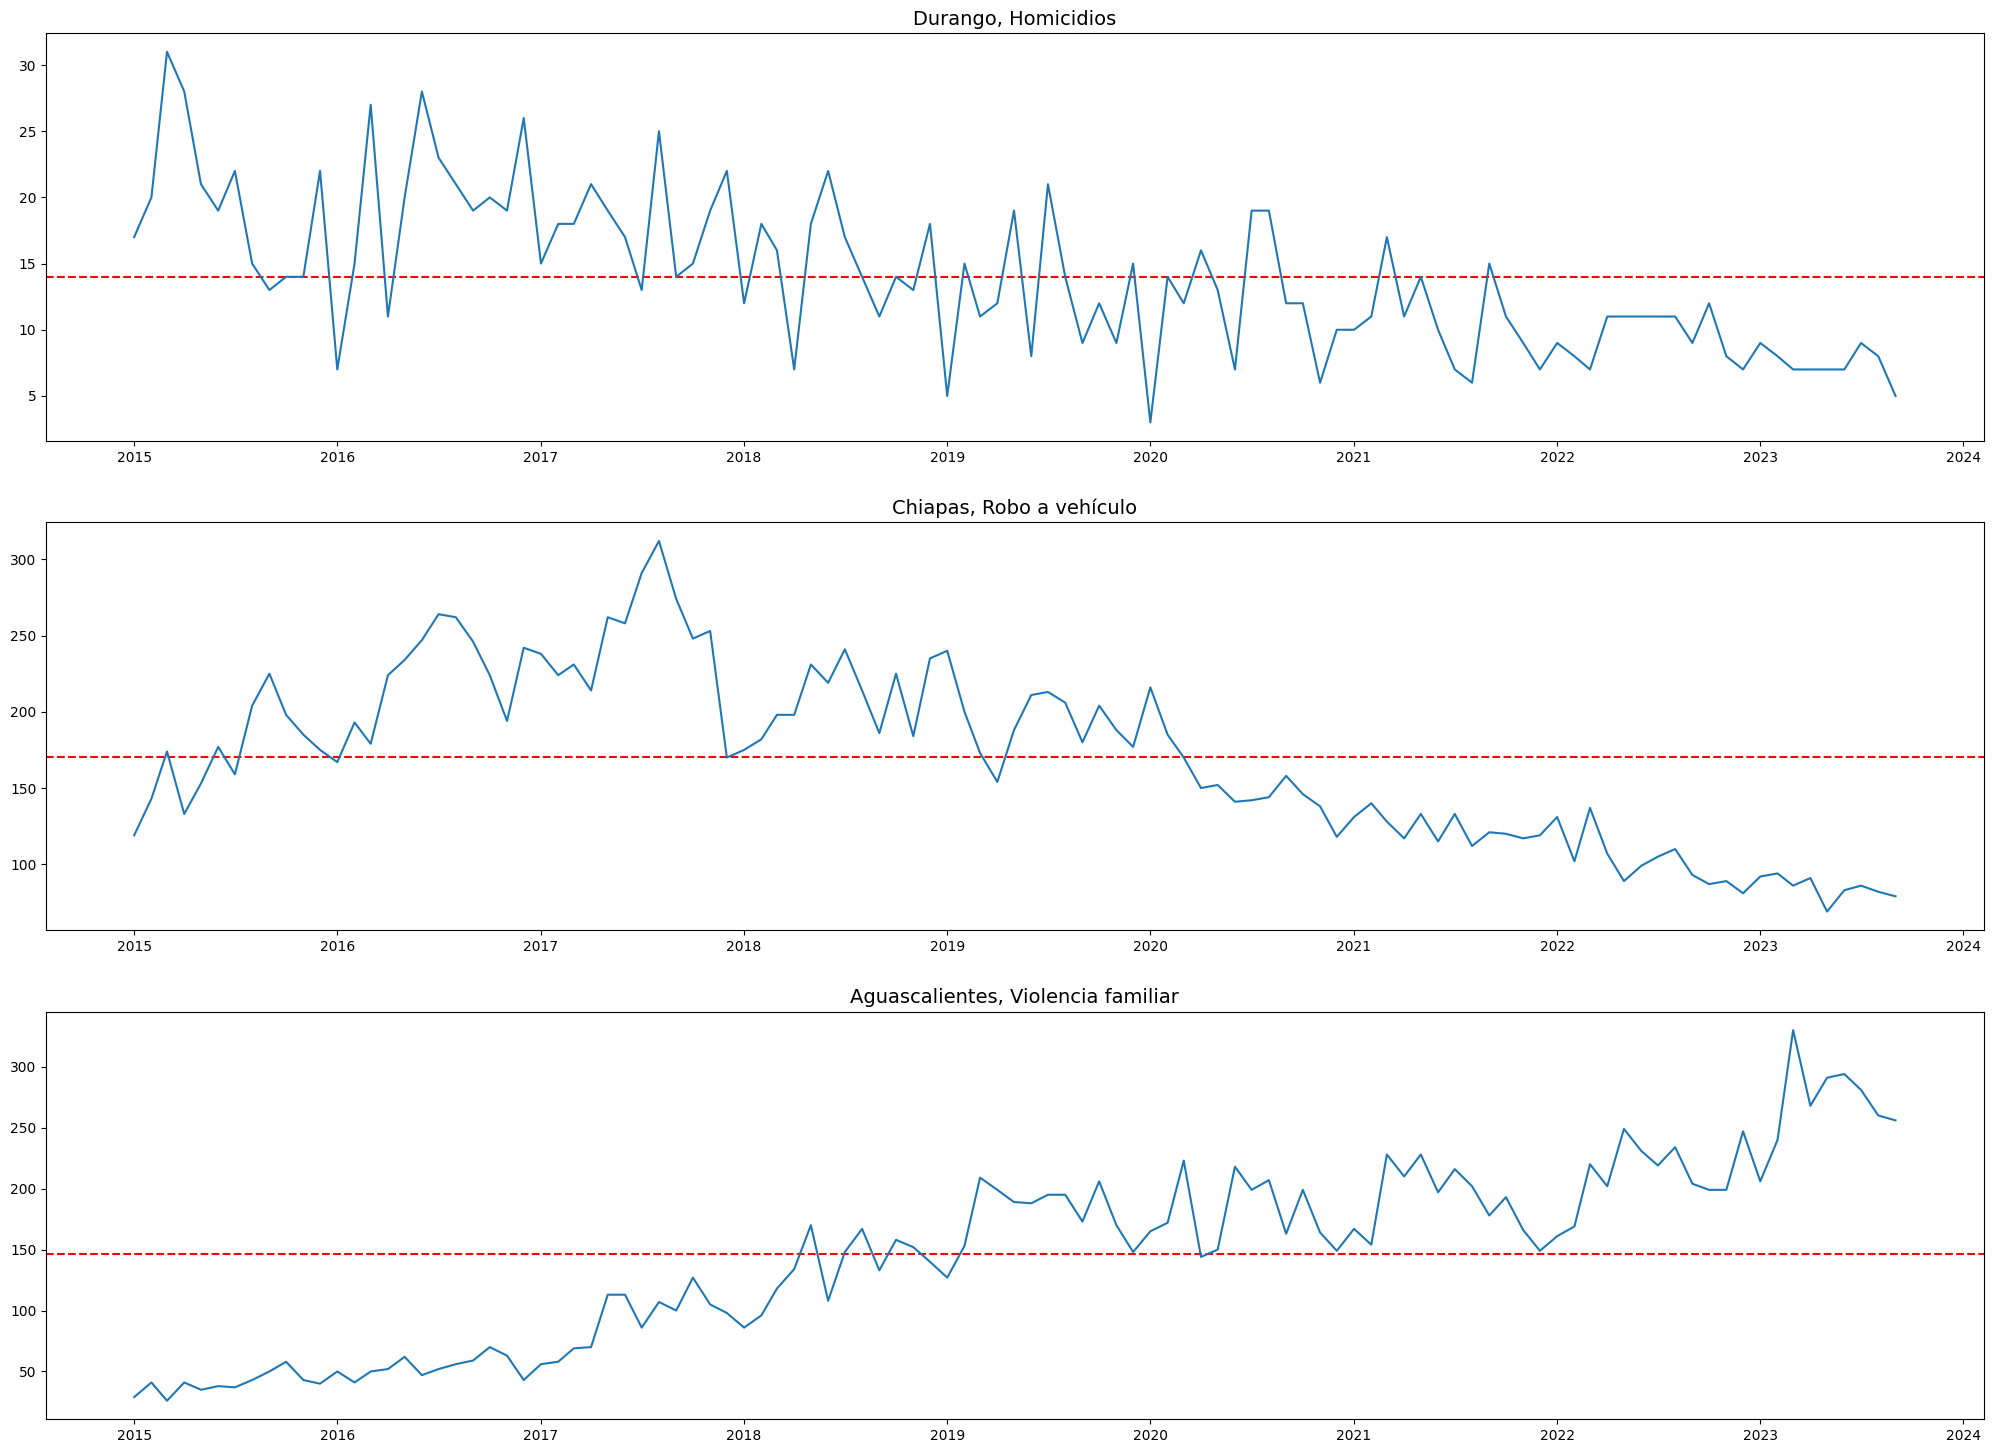

In [66]:

tendencias = [('Durango', 'Homicidios'),
        ('Chiapas', 'Robo a vehículo'),
         ('Aguascalientes', 'Violencia familiar')]

fig, axs = plt.subplots(3,1, figsize = (25,18))

for i, condicion in enumerate(tendencias):
 
    estado1 = series_delitos_filtrables['entidad'] == condicion[0] #condicionar estado
    
    tipo1 = series_delitos_filtrables['delito_semaforo'] == condicion[1] #condicionar tipo de delito
    
    vista = series_delitos_filtrables[estado1 & tipo1]['incidentes'] #vista para facilitar manejo de datos
    
    axs[i].axhline(y=vista.mean(), color='r', linestyle='--', label='Línea Horizontal') #grafica de media
    
    axs[i].plot(vista) #grafica serie

    axs[i].set_title(condicion[0] + ', '+ condicion[1], fontsize=14)
    